<a href="https://colab.research.google.com/github/afsarequebal/AlgoAndDS/blob/master/rnnNb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS 6120: Predicting Retraction Paper using RNN(LSTM)

## Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.utils import resample
import string
import math

warnings.filterwarnings("ignore")

## Reading the data

 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv('retraction.csv', sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 0"])


In [3]:
df.head()

,Reason,Text
0,0,"./jbc.,,""Judith Campisi Farzaneh, Terumi Kohw..."
1,0,"./jbc.,,""Metformin for type diabetes mellitus..."
2,0,"./seals ,,""Clinical Immunology Vol. , No. , A..."
3,1,"./jbc.,,""Full Terms & Conditions of access an..."
4,1,"./ ,,""A dedicated translation factor controls..."


In [4]:
## Renaming the columns so that we understand the columns easily.

## Rename Reason as "spam_or_ham" and Text as "message"

df = df.rename(columns = {"Reason":"Target", "Text":"message"})

In [5]:
df.head()

,Target,message
0,0,"./jbc.,,""Judith Campisi Farzaneh, Terumi Kohw..."
1,0,"./jbc.,,""Metformin for type diabetes mellitus..."
2,0,"./seals ,,""Clinical Immunology Vol. , No. , A..."
3,1,"./jbc.,,""Full Terms & Conditions of access an..."
4,1,"./ ,,""A dedicated translation factor controls..."


## Count plot of the output categories: spam or ham



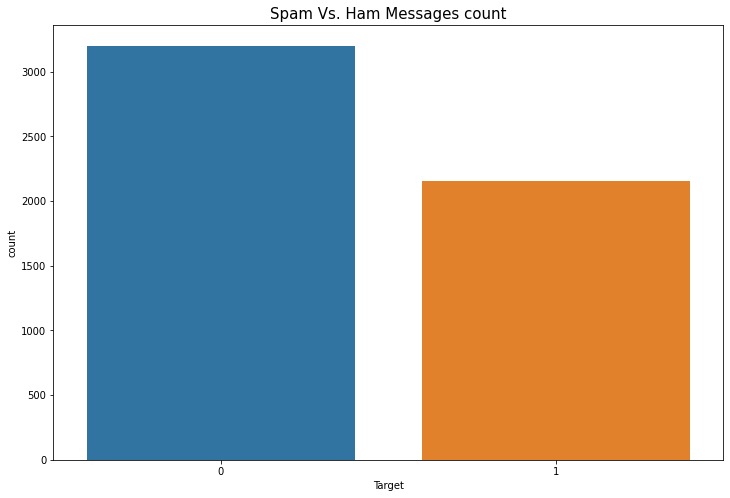

In [6]:
plt.figure(figsize = (12,8))
sns.countplot(x ='Target', data = df)
plt.title("Spam Vs. Ham Messages count", fontsize = 15)
plt.show()

## Upsampling the minority class



In [7]:
from sklearn.utils import resample

df_majority = df[df.Target==0]
df_minority = df[df.Target==1]

spam_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, spam_upsample])  
df_upsampled = df_upsampled.sample(frac = 1)

In [8]:
df_upsampled[df_upsampled['Target']==1].shape

(3202, 2)

In [9]:
df_upsampled[df_upsampled['Target']==0].shape

(3202, 2)

In [56]:
## Considering 3000 spam and 3000 ham data points
spam_data_points_train = df_upsampled[df_upsampled['Target']==1].iloc[:2000]
ham_data_points_train = df_upsampled[df_upsampled['Target']==0].iloc[:2000]

## Considering the remaining data points for test
spam_data_points_test = df_upsampled[df_upsampled['Target']==1].iloc[2000:]
ham_data_points_test = df_upsampled[df_upsampled['Target']==0].iloc[2000:]

## Concatenate the training ham and spam messages
X_train = pd.concat([spam_data_points_train['message'], ham_data_points_train['message']])
## Concatenating the training ham and spam outputs
y_train = pd.concat([spam_data_points_train['Target'], ham_data_points_train['Target']])

## Concatenating the test ham and spam messages
X_test = pd.concat([spam_data_points_test['message'], ham_data_points_test['message']])
## Concatenating the test ham and spam outputs
y_test = pd.concat([spam_data_points_test['Target'], ham_data_points_test['Target']])


In [57]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of spam and ham messages. 
y_train.value_counts()
'''
y_test = y_test.to_numpy()
a = 0 
b = 0
for val in y_train:
  if val == 0:
    a = a+1
  else:
    b = b+1
print(a)
print(b)
c=0
d=0
for val in y_test:
  if val == 0:
    c = c+1
  else:
    d = d+1
print(c)
print(d)
type(y_test)
'''

'\ny_test = y_test.to_numpy()\na = 0 \nb = 0\nfor val in y_train:\n  if val == 0:\n    a = a+1\n  else:\n    b = b+1\nprint(a)\nprint(b)\nc=0\nd=0\nfor val in y_test:\n  if val == 0:\n    c = c+1\n  else:\n    d = d+1\nprint(c)\nprint(d)\ntype(y_test)\n'

In [58]:
y_test.value_counts()

1    1202
0    1202
Name: Target, dtype: int64

## Pre-process the messages



In [59]:
import string
import nltk
import nltk
nltk.download('stopwords')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 

    '''
    message = message.lower()
    message = re.sub(r"http\S+", "", message)
    message = re.sub(r"www.\S+", "", message)
    messages_links_removed = "".join([char for char in message if char not in string.punctuation])
    messages_cleaned = " ".join([word for word in re.split('\W+', messages_links_removed)
        if word not in stopword])
    #text = " ".join([ps.stem(word) for word in re.split('\W+', messages_cleaned)])
    text = " ".join([word for word in re.split('\W+', messages_cleaned)])
    return text


In [61]:
df["message"] = df.message.map(clean_message)

In [62]:
df.iloc[2,1]

' seals clinical immunology vol august pp doiclim available online simultaneous presence mucous membrane pemphigoid pemphigus vulgaris molecular characterization autoantibodies naveed sami kailash c bhol ernst h beutner richard w plunkett kristin leiferman c stephen foster razzaque ahmed department oral medicine harvard school dental medicine boston department medicine new england baptist hospital boston massachusetts beutner laboratories buffalo new york immunodermatology laboratory mayo clinic rochester minnesota mass eye ear infirmary boston massachusetts several reports literature describ ing coexistence features pemphigus vul garis pemphigoid patient de scribe patients clinical histological immunopathological features mucous membrane cicatricial pemphigoid time initial diag nosis patients failed respond clinically conventional systemic agents mean period years hence ivig therapy used prior initiating ivig therapy features mucous mem brane pemphigoid pemphigus vulgaris demonstrated

## Count occurence of words

In [64]:
from collections import Counter

#Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df.message)

In [65]:
num_unique_words = len(counter)

In [66]:
counter

Counter({'jbcjudith': 1,
         'campisi': 29,
         'farzaneh': 7,
         'terumi': 2,
         'kohwi': 12,
         'shigematsu': 33,
         'oliver': 158,
         'bischof': 27,
         'sanjeev': 38,
         'galande': 6,
         'farzin': 3,
         'death': 6880,
         'syndrome': 3833,
         'protein': 32296,
         'apoptotic': 3470,
         'cell': 59231,
         'selective': 2541,
         'cleavage': 1695,
         'blm': 242,
         'bloom': 182,
         'degradation': 2850,
         'post': 7917,
         'translation': 1461,
         'modification': 1562,
         'synthesis': 4825,
         'doi': 6879,
         'jbc': 918,
         'originally': 841,
         'published': 31615,
         'online': 5057,
         'january': 2701,
         'j': 94835,
         'biol': 10712,
         'chem': 9813,
         'updated': 1170,
         'version': 2594,
         'article': 8772,
         'affinity': 1723,
         'sitesfind': 156,
         'article

In [67]:
counter.most_common(5)

[('j', 94835), ('c', 91842), ('cells', 89119), ('p', 81514), ('n', 74167)]

In [71]:
#split dataset into training and validatin set
'''
train_size = int(df.shape[0]*0.8)
train_df = df[:train_size]
val_df = df[train_size:]

#split text and labels
train_sentences = train_df.message.to_numpy()
train_labels = train_df.Target.to_numpy()
val_sentences = val_df.message.to_numpy()
val_labels = val_df.Target.to_numpy()
'''
train_sentences = X_train.to_numpy()
train_labels = y_train.to_numpy()
val_sentences = X_test.to_numpy()
val_labels = y_test.to_numpy()


In [72]:
train_sentences.shape, val_sentences.shape
'''
a = 0 
b = 0
for val in train_labels:
  if val == 0:
    a = a+1
  else:
    b = b+1
print(a)
print(b)
c=0
d=0
for val in val_labels:
  if val == 0:
    c = c+1
  else:
    d = d+1
print(c)
print(d)
print(type(train_labels))
print(type(train_sentences))
'''

'\na = 0 \nb = 0\nfor val in train_labels:\n  if val == 0:\n    a = a+1\n  else:\n    b = b+1\nprint(a)\nprint(b)\nc=0\nd=0\nfor val in val_labels:\n  if val == 0:\n    c = c+1\n  else:\n    d = d+1\nprint(c)\nprint(d)\nprint(type(train_labels))\nprint(type(train_sentences))\n'

In [73]:
#Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

#vectorize a text corpus each text into a sequence of integers

tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)

In [75]:
word_index = tokenizer.word_index

In [76]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [77]:
#print(train_sentences[10:15])
#print(train_sequences[10:15])
max_length = -1
for seq in train_sequences:
    if len(seq) > max_length:
        max_length = len(seq)
max_length = 5000

In [78]:
#Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Max number of words in sequence
train_padded = pad_sequences(train_sequences,maxlen = max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen = max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape
#train_sequences.shape, val_sequences.shape

((4000, 5000), (2404, 5000))

In [79]:
#print(train_sentences[10])
#print(train_sequences[10])
print(train_padded[10])

[ 262 2290    2 ...    0    0    0]


In [80]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])    


In [81]:
reverse_word_index

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'in',
 5: 'a',
 6: 'to',
 7: 'for',
 8: 'with',
 9: '\x1a',
 10: 'is',
 11: 'by',
 12: 'was',
 13: 'that',
 14: 'were',
 15: 'as',
 16: 'on',
 17: 'or',
 18: 'j',
 19: 'from',
 20: 'm',
 21: 'at',
 22: 'this',
 23: 'c',
 24: 'are',
 25: 's',
 26: 'be',
 27: 'cells',
 28: 'p',
 29: 'd',
 30: 'n',
 31: 'not',
 32: 't',
 33: 'e',
 34: 'h',
 35: 'al',
 36: 'et',
 37: 'an',
 38: 'b',
 39: 'r',
 40: 'we',
 41: 'cell',
 42: 'i',
 43: 'l',
 44: 'g',
 45: 'patients',
 46: 'data',
 47: 'study',
 48: 'it',
 49: 'which',
 50: 'no',
 51: 'fig',
 52: 'have',
 53: 'treatment',
 54: 'after',
 55: 'these',
 56: 'k',
 57: 'f',
 58: 'control',
 59: 'analysis',
 60: 'can',
 61: 'all',
 62: 'has',
 63: 'group',
 64: 'using',
 65: 'expression',
 66: 'studies',
 67: 'also',
 68: 'used',
 69: 'between',
 70: 'results',
 71: 'been',
 72: 'two',
 73: 'w',
 74: 'protein',
 75: 'only',
 76: 'one',
 77: 'o',
 78: 'effect',
 79: 'y',
 80: 'may',
 81: '\x1a\x1a',
 82: 'other',
 83

In [82]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])  

In [83]:
decoded_text = decode(train_sequences[10])
print(train_sequences[10])
print(decoded_text)

[262, 2290, 2, 1834, 54, 2230, 3, 439, 86, 2, 1, 317, 2, 22, 210, 11, 5, 2996, 2668, 1732, 1309, 22, 210, 62, 71, 143, 6, 26, 4, 2522, 2, 2967, 733, 1541, 40, 2341, 2427, 1, 317, 2, 22, 210, 1670, 1602, 205, 26, 510, 6, 1444, 61, 1158, 441, 6, 22, 210, 1, 1883, 646, 2, 22, 210, 62, 1, 2041, 6, 2890, 22, 687, 11, 2750, 3064, 682, 189, 682, 8461, 458, 1265, 16, 831, 4955, 21633, 1792, 2, 5689, 1496, 429, 119, 16, 2732, 7814, 3382, 1503, 1503, 716, 55599, 345, 735, 55599, 657, 907, 28282, 381, 2616, 738, 10645, 4944, 58, 683, 10645, 381, 7721, 5088, 55599, 2815, 1327, 13216, 2265, 381, 8680, 8608, 11831, 3, 1750, 657, 513, 55599, 657, 907, 28282, 381, 70283, 12, 495, 13, 95, 14, 176, 798, 114, 15, 656, 208, 2077, 1462, 102, 1, 6395, 4354, 1792, 14243, 12, 536, 4, 1, 1943, 429, 1792, 224, 3, 48, 12, 2760, 1669, 13, 1, 1631, 7814, 1792, 9781, 12, 4124, 116, 1, 14243, 709, 6, 350, 5, 156, 2732, 7814, 1792, 1631, 7814, 3, 6395, 4354, 1792, 2009, 14243, 22, 156, 2732, 709, 60, 6756, 1, 1792, 2

In [84]:
#Create LSTM model
from tensorflow import keras
from tensorflow.keras import layers

#Embedding: https://www.tensorflow.org/tutorials/text/word_embeddings

#Turns positive integers (indexes into dense vectors of fixed size. (other approach could be one-hot-encoding)

#Word embeddings give us a way to use an efficient, dense representation in which similar words have
#a similar encoding. Importantly you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify)

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length = max_length))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where None is the batch dimension.

#model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.LSTM(16, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 5000, 32)          13368768  
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 13,371,921
Trainable params: 13,371,921
Non-trainable params: 0
_________________________________________________________________


In [85]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim=keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [ ]:

model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels),verbose=2)



Epoch 1/20
125/125 - 606s - loss: 0.6927 - accuracy: 0.5130 - val_loss: 0.6899 - val_accuracy: 0.5666 - 606s/epoch - 5s/step
Epoch 2/20
125/125 - 512s - loss: 0.6308 - accuracy: 0.6395 - val_loss: 0.6481 - val_accuracy: 0.5774 - 512s/epoch - 4s/step
Epoch 3/20
125/125 - 513s - loss: 0.4979 - accuracy: 0.6855 - val_loss: 0.6981 - val_accuracy: 0.5720 - 513s/epoch - 4s/step
Epoch 4/20
125/125 - 509s - loss: 0.4388 - accuracy: 0.7082 - val_loss: 0.7220 - val_accuracy: 0.5865 - 509s/epoch - 4s/step
Epoch 5/20
125/125 - 513s - loss: 0.4225 - accuracy: 0.7013 - val_loss: 0.7489 - val_accuracy: 0.5853 - 513s/epoch - 4s/step
Epoch 6/20
125/125 - 510s - loss: 0.4170 - accuracy: 0.7138 - val_loss: 0.8334 - val_accuracy: 0.5661 - 510s/epoch - 4s/step
Epoch 7/20
125/125 - 512s - loss: 0.4168 - accuracy: 0.6945 - val_loss: 0.8026 - val_accuracy: 0.5836 - 512s/epoch - 4s/step
Epoch 8/20
125/125 - 529s - loss: 0.4124 - accuracy: 0.7130 - val_loss: 0.8132 - val_accuracy: 0.5869 - 529s/epoch - 4s/step
